# How-to use JAX with `qiskit-dynamics`


JAX enables just-in-time compilation, automatic differentation, and GPU execution. JAX is integrated into `qiskit-dynamics` via the `dispatch` submodule, which allows most parts of the package to be executed with either `numpy` or `jax.numpy`. 

This guide addresses the following topics:

1. How do I configure dynamics to run with JAX?
2. How do I write code using dispatch that can be executed with either `numpy` or JAX?
3. How do I write JAX-transformable functions using the objects and functions in `qiskit-dynamics`?
4. Gotchas when using JAX with dynamics.

## 1. How do I configure dynamics to run with JAX?

The `dispatch` submodule provides a means of controlling whether array operations are performed using `numpy` or `jax.numpy`. In many cases, the "default backend" is used to determine which of the two options is used.

In [1]:
# configure jax to use 64 bit mode
import jax
jax.config.update("jax_enable_x64", True)

# import dispatch and set default backend
from qiskit_dynamics import dispatch
dispatch.set_default_backend('jax')

The default backend can be observed via:

In [2]:
dispatch.default_backend()

'jax'

## 2. How do I write code using dispatch that can be executed with either `numpy` or JAX?

The `dispatch.Array` class wraps both `numpy` and `jax.numpy` arrays. The particular type is indicated by the `backend` property, and `numpy` functions called on an `Array` will automatically be dispatched to `numpy` or `jax.numpy` based on the `Array`'s backend. See the API documentation for `qiskit_dynamics.dispatch` for details.

## 3. How do I write JAX-transformable functions using the objects and functions in `qiskit-dynamics`?

JAX-transformable functions must be:
- JAX-executable.
- Take JAX arrays as input and output (see the [JAX documentation](https://jax.readthedocs.io/en/latest/) for more details on accepted input and output types).
- Pure, in the sense that they have no side-effects.

The previous section shows how to handle the first two points using `dispatch` and `Array`. The last point further restricts the type of code that can be safely transformed. Dynamics uses various objects which can be updated by setting properties (models, solvers). If a function to be transformed requires updating an already-constructed object of this form, it is necessary to first make a *copy*.

We demonstrate this process for both just-in-time compilation and automatic differentiation in the context of an anticipated common use-case: parameterized simulation of a model of a quantum system.

### 3.1 Just-in-time compiling a parameterized simulation

Just-in-time compilation is performed using the `jax.jit` function. For convenience, the `dispatch.wrap` function can be used to transform `jax.jit` to also work on functions that have `Array` objects as inputs and outputs.

In [3]:
jit = dispatch.wrap(jax.jit, decorator=True)

Construct a `Solver` instance with a model that will be used to solve.

In [4]:
import numpy as np
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver
from qiskit_dynamics.signals import Signal
from qiskit_dynamics.dispatch import Array

r = 0.5
w = 1.
X = Operator.from_label('X')
Z = Operator.from_label('Z')

static_hamiltonian = 2 * np.pi * w * Z/2
hamiltonian_operators = [2 * np.pi * r * X/2]

solver = Solver(static_hamiltonian=static_hamiltonian,
                hamiltonian_operators=hamiltonian_operators,
                rotating_frame=static_hamiltonian)

Next, define the function to be compiled:
- The input is the amplitude of a constant-envelope signal on resonance, driven over time $[0, 3]$.
- The output is the state of the system, starting in the ground state, at `100` points over the total evolution time.

In [5]:
def sim_function(amp):
    
    # define a constant signal 
    amp = Array(amp)
    signals = [Signal(amp, carrier_freq=w)]
    
    # make copy and set signals
    solver_copy = solver.copy()
    solver.signals = signals
    
    # simulate and return results
    # setting user_frame tells solve that states should be specified and returned in the frame
    # of the drift
    results = solver_copy.solve(t_span=[0, 3.], 
                                t_eval=np.linspace(0, 3., 100), 
                                y0=np.array([0., 1.], dtype=complex),  
                                method='jax_odeint')
    return results.y

Compile the function.

In [6]:
fast_sim = jit(sim_function)

The first time the function is called, it will compile and then execute. Hence, the time taken  on the first call *includes* compilation time.

In [7]:
%time ys = fast_sim(1.).block_until_ready()

CPU times: user 660 ms, sys: 11.9 ms, total: 672 ms
Wall time: 667 ms


On subsequent calls the compiled function is directly executed, demonstrating the true speed of the compiled function.

In [8]:
%timeit fast_sim(1.).block_until_ready()

86.5 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


We use this function to plot the $Z$ expectation value over a range of input amplitudes.

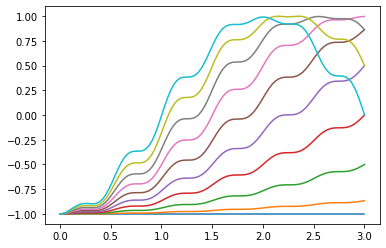

In [9]:
import matplotlib.pyplot as plt

for amp in np.linspace(0, 1, 10):
    ys = fast_sim(amp)
    plt.plot(np.linspace(0, 3., 100), np.real(np.abs(ys[:, 0])**2-np.abs(ys[:, 1])**2))

### 3.2 Automatically differentiating a parameterized simulation

Next, we use `jax.grad` to automatically differentiate a parameterized simulation. In this case, `jax.grad` requires that the output be a real number, so we specifically compute the population in the excited state at the end of the previous simulation

In [10]:
def excited_state_pop(amp):
    yf = sim_function(amp)[-1]
    return np.abs(Array(yf[0]))**2

Wrap `jax.grad` in the same way, then differentiate and compile `excited_state_pop`.

In [11]:
grad = dispatch.wrap(jax.grad, decorator=True)

excited_pop_grad = jit(grad(excited_state_pop))

As before, the first execution includes compilation time.

In [12]:
%time excited_pop_grad(1.).block_until_ready()

CPU times: user 1.73 s, sys: 17.1 ms, total: 1.74 s
Wall time: 1.74 s


Array(-2.33674168)

Subsequent runs of the function reveal the true time.

In [13]:
%timeit excited_pop_grad(1.).block_until_ready()

450 µs ± 37.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## 4. Gotchas when using JAX with dynamics

### 4.1 JAX must be set as the default backend before building any objects in dynamics

To get dynamics to run with JAX, it is necessary to configure dynamics to run with JAX _before_ building any objects or running any functions. The internal behaviour of some objects is modified by what the default backend is _at the time of instantiation_. For example, at instantiation the operators in a model or `Solver` instance will be wrapped in an `Array` whose backend is the current default backend, and changing the default backend after building the object won't change this.

### 4.2 Dynamics does not currently support JAX sparse types

Sparse evaluation modes for models and solvers cannot be used when JAX is the default backend. Setting a sparse evaluation mode when JAX is the default backend will result in an error.